In [3]:
### Load necessary libraries ###
import glob
import os
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, confusion_matrix

import tensorflow as tf
from tensorflow import keras

# Global Configuration variables

In [6]:
# Debug and test variables
REDUCED_MODE = 0  # Do not process all the audio in the dataset (for faster execution during script development)
REDUCED_MODE_AUDIONUM = 15 # Number of dataset audios per folder to process in the reduced-mode.

# Audio processing variables
AUDIO_SR = 44100 # Audio sampling in Hertz
AUDIO_N_FFT = 2048 # Samples per FFT window
AUDIO_HOP_LEN = 512
AUDIO_N_MELS = 60
AUDIOSEG_SIZE = 41 # windows per subAudio / segment
AUDIOSEG_OVERLAP = 0.5 # normalized

# Paths and folders
audiosPath = 'UrbanSounds8K/1_audioFiles/'
processedPath = "UrbanSounds8K/2_featuresProcessed/"
confusionPath = "UrbanSounds8K/3_confusionMatrix/"
confusionFile = "confusion_matrix"
audiosSubPaths = np.array(['fold1','fold2','fold3','fold4','fold5','fold6','fold7','fold8','fold9','fold10'])


# Methods for preprocessing and feature extraction

In [79]:
# Divide an audio file into shorter parts.
def audioSegmentation(audioData, subAudioSize, overlapFactor = AUDIOSEG_OVERLAP):
    start = 0
    while start < len(audioData):
        yield int(start), int(start + subAudioSize)
        start += (subAudioSize // (1/(1-overlapFactor)))     

In [80]:
### Define helper functions ###
def extractSoundFeature(audiosPath,audiosSubPath,audiosExtension="*.wav", n_mels=AUDIO_N_MELS, n_windows=AUDIOSEG_SIZE, hopLength = AUDIO_HOP_LEN):
    
    subAudioSize = hopLength * (n_windows - 1)
    features_AM, classes_A = [], []
    
    # Map all audio samples paths inside the folder
    allAudiosPath_A = glob.glob(os.path.join(audiosPath, audiosSubPath, audiosExtension));

    # Iterate and extract features from each audio
    idxAudio = 0
    idxSegment = 0
    for audioPath in allAudiosPath_A:
        idxAudio=idxAudio+1;
        # Early stop for reduced mode
        if REDUCED_MODE==1 and idxAudio == REDUCED_MODE_AUDIONUM:
            break;
        
        subAudioLogSpect_AM, subAudioClass = [], []

        # Extract '.wav' audio to an 1-D array + audio classification
        audioData_A, sr = librosa.load(audioPath, sr = AUDIO_SR)
        audioClass = int(audioPath.split('/')[2].split('-')[1])

        # Loop and extract all audio features from subsegments
        for (start,end) in audioSegmentation(audioData_A, subAudioSize):
            if(len(audioData_A[start:end]) == subAudioSize):
                idxSegment = idxSegment+1;
                # Append audio class to segments class array
                subAudioClass.append(audioClass)
                
                #Extract audio data - 1D Array
                segAudioData_A = audioData_A[start:end]
                
                # Transform to spectogram in decibels - 2D Matrix
                segAudioSpect_M = librosa.feature.melspectrogram(y=segAudioData_A, n_mels=n_mels)
                segAudioSpectDecibels_M = librosa.amplitude_to_db(segAudioSpect_M)

                # Reshape and append to preprocessed spectograms
                segAudioSpectDecibels_M = segAudioSpectDecibels_M.T.flatten()[:, np.newaxis].T
                subAudioLogSpect_AM.append(segAudioSpectDecibels_M)
                
        subAudioLogSpect_AM = np.asarray(subAudioLogSpect_AM).reshape(len(subAudioLogSpect_AM),n_mels,n_windows,1)

        if len(subAudioLogSpect_AM) > 0: # if not empty, concatenate in features / classes array
            features_AM.append(subAudioLogSpect_AM)
            classes_A.append(subAudioClass)
    
    print('Num of segments for this folder - ', idxSegment, ' - out of - ', idxAudio , ' audios.');

    return features_AM, classes_A

# CNN Model Definition - with ReLu activation

In [1]:
### Define convolutional network architecture ###
def CNN_modelDefinition(useLeakyRelu = 0):
    keras.backend.clear_session()
    
    num_filters = [24,32,64,128] 
    pool_size = (2, 2) 
    kernel_size = (3, 3)  
    input_shape = (60, 41, 1)
    num_classes = 10
    
    # ---------- Convolutional + Pooling Layer 1 ---------- #
    model = keras.models.Sequential()
    model.add(keras.layers.Conv2D(80, kernel_size, padding="same", input_shape=input_shape, dilation_rate= 1))
    model.add(keras.layers.BatchNormalization())
    if useLeakyRelu == 0:
        model.add(keras.layers.Activation("relu"))
    else:
        model.add(keras.layers.LeakyReLU(alpha=0.1))
    model.add(keras.layers.MaxPooling2D(pool_size=pool_size))

    #model.add(keras.layers.Dropout(0.2))

    # ---------- Convolutional + Pooling Layer 2 ---------- #
    model.add(keras.layers.Conv2D(80, kernel_size, padding="same", dilation_rate=2))
    model.add(keras.layers.BatchNormalization())
    if useLeakyRelu == 0:
        model.add(keras.layers.Activation("relu"))
    else:
        model.add(keras.layers.LeakyReLU(alpha=0.1))
    model.add(keras.layers.MaxPooling2D(pool_size=pool_size))
    
    # ---------- Pooling Layer Layer ---------- #
    model.add(keras.layers.GlobalMaxPooling2D())

    # ---------- Flat Layers ---------- #
    model.add(keras.layers.Dense(512, activation="relu"))
    #model.add(keras.layers.Dense(64, activation="relu"))
    model.add(keras.layers.Dense(num_classes, activation="softmax"))

    model.compile(optimizer=keras.optimizers.Adam(1e-4), loss=keras.losses.SparseCategoricalCrossentropy(), 
                   metrics=["accuracy"])
    return model

# Audio Processing and Features Extraction

In [82]:
# Pre-process and extract feature from the data
for audioSubPath in audiosSubPaths:
    features_AM, classes_A = extractSoundFeature(audiosPath,audioSubPath)
    np.savez("{0}{1}".format(processedPath, audioSubPath), features=features_AM, classes=classes_A);

Num of segments for this folder -  12539  - out of -  873  audios.


c:\Users\SZM1JVL\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\lib\npyio.py:713: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  val = np.asanyarray(val)


Num of segments for this folder -  12419  - out of -  888  audios.
Num of segments for this folder -  13465  - out of -  925  audios.
Num of segments for this folder -  13975  - out of -  990  audios.
Num of segments for this folder -  13132  - out of -  936  audios.
Num of segments for this folder -  11721  - out of -  823  audios.
Num of segments for this folder -  12146  - out of -  838  audios.
Num of segments for this folder -  11406  - out of -  806  audios.
Num of segments for this folder -  11779  - out of -  816  audios.
Num of segments for this folder -  12027  - out of -  837  audios.


# CNN Training and Metrics Extraction

In [7]:
### Train and evaluate via 10-audiosSubPaths cross-validation ###
kf = KFold(n_splits=10)

allConfusionMatrix_AM = [] # List containing all confusion matrix for all K-Fold Train-Test
allFitResults_A = []

# Loop to traint-test in all folder combinations.
idx = 0
for train_index, test_index in kf.split(audiosSubPaths):
    idx= idx+1
    
    print('--> Starting a loop! - Folder ', idx)

    x_train, y_train = [], []

    # ---------------- STEP 1 ----------------
    # Load training data from 9 out of 10 folders 
    # Loop through all training folders and gather data in single feature array
    for idxTrainFolder in train_index:
        print('-> Getting data from TRAINING folder ', idxTrainFolder+1)
        # Read pre-saved features or segments of an audio file (pre-processed)
        train_data = np.load("{0}/{1}.npz".format(processedPath,audiosSubPaths[idxTrainFolder]), allow_pickle=True)

        # Get the 'features' and 'classes' from current train folder
        features = np.concatenate(train_data["features"], axis=0) 
        classes = np.concatenate(train_data["classes"], axis=0)

        # Append all the 'features' and 'classes' train datasets 
        # in a single list containing all train folders data
        x_train.append(features)
        y_train.append(classes)

    # Stack all the segments as if they are 'individual' features
    x_train = np.concatenate(x_train, axis = 0).astype(np.float32)
    y_train = np.concatenate(y_train, axis = 0).astype(np.float32)
    print('-> TRAIN dataset size: ', len(x_train));
    
    # ---------------- STEP 2 ----------------
    # Load test data from 1 out of 10 folders 
    # Load test data from the test folder
    print('\n-> Getting data from TESTING folder ', test_index+1)
    test_data = np.load("{0}/{1}.npz".format(processedPath, audiosSubPaths[test_index][0]), allow_pickle=True)
    x_test = np.concatenate(test_data["features"], axis = 0).astype(np.float32)
    y_test = np.concatenate(test_data["classes"], axis = 0).astype(np.float32)
    print('-> TEST dataset size: ', len(x_test));

    CNN_model = CNN_modelDefinition(useLeakyRelu=1)
    
    print('\n--> Fitting model!')
    allFitResults_A.append(CNN_model.fit(x_train, y_train,validation_data=(x_test, y_test), epochs = 12, batch_size = 24, verbose = 1))
    
    # Predict results from test data
    y_test_pred = [];
    y_test_pred = CNN_model.predict(x_test); # Categorical results
    y_test_pred = np.asarray( tf.argmax(y_test_pred, axis=1)  ) # OHE to Category

    # Early stop for reduced mode
    if REDUCED_MODE == 1:
        break;

    # Append the confusion matrix of this K-Fold run to a matirx list
    allConfusionMatrix_AM.append(confusion_matrix(y_test_pred, y_test))


# Save the resulting confusion matrices
np.savez("{0}{1}".format(confusionPath, confusionFile), allConfusionMatrix=allConfusionMatrix_AM);

--> Starting a loop! - Folder  1
-> Getting data from TRAINING folder  2
-> Getting data from TRAINING folder  3
-> Getting data from TRAINING folder  4
-> Getting data from TRAINING folder  5
-> Getting data from TRAINING folder  6
-> Getting data from TRAINING folder  7
-> Getting data from TRAINING folder  8
-> Getting data from TRAINING folder  9
-> Getting data from TRAINING folder  10
-> TRAIN dataset size:  112070

-> Getting data from TESTING folder  [1]
-> TEST dataset size:  12539

--> Fitting model!
Epoch 1/12
 291/4670 [>.............................] - ETA: 5:48 - loss: 1.8615 - accuracy: 0.3403

KeyboardInterrupt: 

Class identifiers according to UrbanSounds 8k :

0 = air_conditioner
1 = car_horn
2 = children_playing
3 = dog_bark
4 = drilling
5 = engine_idling
6 = gun_shot
7 = jackhammer
8 = siren
9 = street_music

In [ ]:
plt.imshow(allConfusionMatrix_AM[0], cmap='binary', interpolation='nearest')
plt.colorbar()
plt.show()

IndexError: list index out of range

In [ ]:
# Histogram of samples per class
np.asarray(classes_A).plot.hist(bins=12, alpha=0.5);

C:\Users\SZM1JVL\AppData\Local\Temp\ipykernel_31388\3883445798.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  np.asarray(classes_A).plot.hist(bins=12, alpha=0.5);


AttributeError: 'numpy.ndarray' object has no attribute 'plot'

In [ ]:
test_data["classes"].plot.hist(bins=12, alpha=0.5);


AttributeError: 'numpy.ndarray' object has no attribute 'plot'

(array([118.,   0.,   0.,   0.,   0.,   0.,   0.,  10.,   0., 160.]),
 array([3. , 3.4, 3.8, 4.2, 4.6, 5. , 5.4, 5.8, 6.2, 6.6, 7. ]),
 <BarContainer object of 10 artists>)

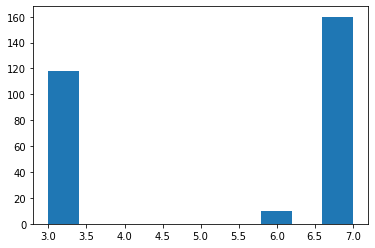

In [ ]:
# Histogram of data per class
plt.hist(np.concatenate(test_data["classes"], axis=0))